# Acquiring dataset

In [2]:
import os
from zipfile import ZipFile

datasets_folder = "/content/drive/My Drive/8th_sem_project/Latest/"
dataset_name = "custom_augmented_500_125"
zip_path = f"{datasets_folder}{dataset_name}.zip"

if not os.path.isfile(zip_path):
    raise Exception("Dataset file not found!",zip_path)

unzip_path = "/content/datasets/"
dataset_path = f"{unzip_path}{dataset_name}"

if os.path.isdir(dataset_path):
    print("Dataset already unzipped!")
else:
    with ZipFile(zip_path, 'r') as zip_file:    
        # extracting all the files 
        print(f'Extracting {dataset_name} now...') 
        zip_file.extractall(unzip_path)
    print("Extraction complete")

Extracting custom_augmented_500_125 now...
Extraction complete


# Imports

In [3]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#@title Check for GPU
use_gpu = True #@param {type:"boolean"}
if use_gpu:
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

# Prepare dataset

In [5]:
classes = ["Bacterial leaf blight", "Brown spot", "Leaf smut", "Blast"]


In [6]:
if not os.path.isdir(dataset_path):
    raise Exception("Dataset directory not found!")
    
train_path = f"{dataset_path}/train"
test_path = f"{dataset_path}/test"
valid_path = f"{dataset_path}/test"

In [7]:
base_model_func = tf.keras.applications.densenet.DenseNet201
preprocess_input = tf.keras.applications.densenet.preprocess_input

IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [8]:
BATCH_SIZE=50       #@param

In [9]:
train_batches = ImageDataGenerator(preprocessing_function=preprocess_input)\
    .flow_from_directory(directory=train_path, target_size=IMG_SIZE, classes=classes, batch_size=BATCH_SIZE)

valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input)\
    .flow_from_directory(directory=valid_path, target_size=IMG_SIZE, classes=classes, batch_size=BATCH_SIZE)

test_batches = ImageDataGenerator(preprocessing_function=preprocess_input)\
    .flow_from_directory(directory=test_path, target_size=IMG_SIZE, classes=classes, batch_size=BATCH_SIZE, shuffle=False)

Found 2000 images belonging to 4 classes.
Found 500 images belonging to 4 classes.
Found 500 images belonging to 4 classes.


In [14]:
imgs, labels = next(train_batches)

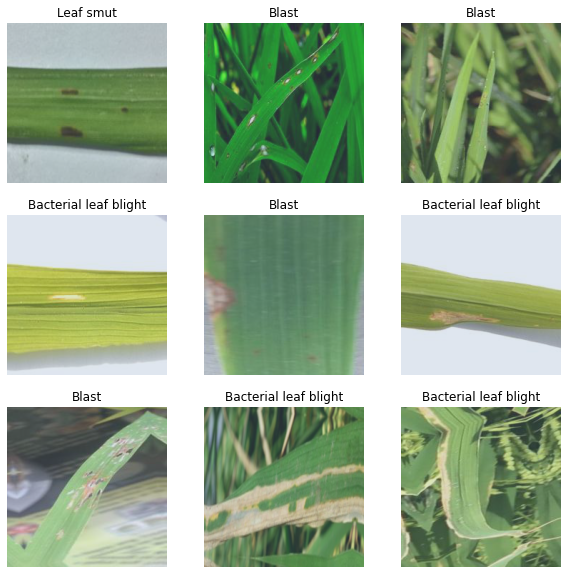

In [15]:
plt.figure(figsize=(10, 10))

for i in range(9):
    img = imgs[i]
    label = classes[np.argmax(labels[i])]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((img+3)/6)
    # print(img.min())
    plt.title(label)
    plt.axis("off")

# Prepare model

In [ ]:
base_model = base_model_func(input_shape=IMG_SHAPE, include_top=False)

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
DROPOUT_RATE=0.3    #@param

In [ ]:
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_layer = tf.keras.layers.Dropout(DROPOUT_RATE)
prediction_layer = tf.keras.layers.Dense(len(classes), activation=tf.nn.softmax)

inputs = tf.keras.Input(shape=IMG_SHAPE)

x = base_model(inputs, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 7684      
Total params: 18,329,668
Trainable params: 7,684
Non-trainable params: 18,321,984
_________________________________________________________________


# Train

In [ ]:
base_learning_rate = 0.0001   #@param
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
initial_epochs = 30   #@param

In [ ]:
history = model.fit(x=train_batches, validation_data=valid_batches, epochs=initial_epochs, verbose=2)

Epoch 1/30
40/40 - 70s - loss: 1.6186 - accuracy: 0.2590 - val_loss: 1.4203 - val_accuracy: 0.3050
Epoch 2/30
40/40 - 19s - loss: 1.3634 - accuracy: 0.3865 - val_loss: 1.2391 - val_accuracy: 0.4650
Epoch 3/30
40/40 - 19s - loss: 1.1987 - accuracy: 0.4865 - val_loss: 1.0955 - val_accuracy: 0.6100
Epoch 4/30
40/40 - 19s - loss: 1.0773 - accuracy: 0.5480 - val_loss: 0.9864 - val_accuracy: 0.6800
Epoch 5/30
40/40 - 19s - loss: 0.9632 - accuracy: 0.6065 - val_loss: 0.8969 - val_accuracy: 0.7450
Epoch 6/30
40/40 - 19s - loss: 0.8784 - accuracy: 0.6600 - val_loss: 0.8271 - val_accuracy: 0.7650
Epoch 7/30
40/40 - 19s - loss: 0.8303 - accuracy: 0.6880 - val_loss: 0.7654 - val_accuracy: 0.7600
Epoch 8/30
40/40 - 19s - loss: 0.7721 - accuracy: 0.7180 - val_loss: 0.7162 - val_accuracy: 0.7500
Epoch 9/30
40/40 - 19s - loss: 0.7315 - accuracy: 0.7310 - val_loss: 0.6748 - val_accuracy: 0.7850
Epoch 10/30
40/40 - 19s - loss: 0.6765 - accuracy: 0.7580 - val_loss: 0.6413 - val_accuracy: 0.7900
Epoch 11/

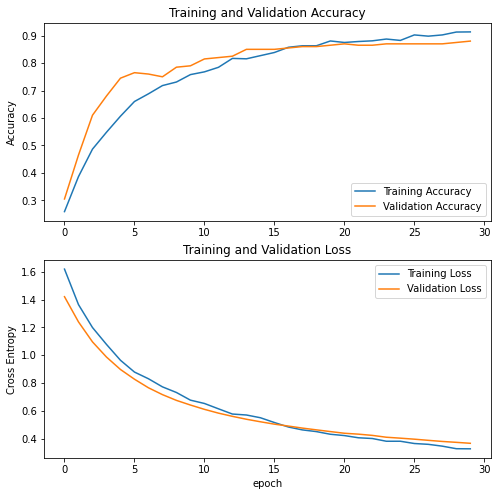

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    # plt.xlabel('Predicted label')
    plt.gcf().text(1, 0.5, 'accuracy={:02.3f}%'.format(accuracy*100), fontsize=16)
    # plt.subplots_adjust(left=0.25)
    plt.show()

In [ ]:
# PREDICTIONS
predictions = model.predict(x=test_batches, verbose=0)

In [ ]:
# calculating CONFUSION MATRIX
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

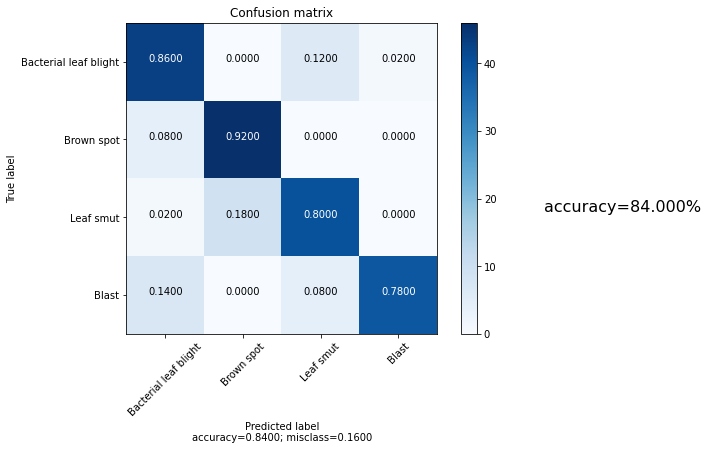

In [ ]:
plot_confusion_matrix(cm, classes)

# Fine Tuning

In [ ]:
len(base_model.layers)

707

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_from = 100    #@param

# Freeze all the layers before the `fine_tune_from` layer
for layer in base_model.layers[:fine_tune_from]:
  layer.trainable =  False

In [ ]:
finetune_learning_rate = 0.000005   #@param
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=finetune_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 7684      
Total params: 18,329,668
Trainable params: 17,295,940
Non-trainable params: 1,033,728
_________________________________________________________________


In [ ]:
total_epochs = initial_epochs

## Fine Tune Training

In [ ]:
fine_tune_epochs = 5   #@param
prev_epochs = total_epochs
total_epochs =  total_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=prev_epochs,
                         validation_data=valid_batches, 
                         verbose=2)

Epoch 41/45
40/40 - 57s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2660 - val_accuracy: 0.9300
Epoch 42/45
40/40 - 57s - loss: 0.0018 - accuracy: 0.9990 - val_loss: 0.3279 - val_accuracy: 0.9250
Epoch 43/45
40/40 - 57s - loss: 0.0019 - accuracy: 0.9990 - val_loss: 0.4925 - val_accuracy: 0.9050
Epoch 44/45
40/40 - 57s - loss: 8.0442e-04 - accuracy: 0.9995 - val_loss: 0.3015 - val_accuracy: 0.9250
Epoch 45/45
40/40 - 57s - loss: 0.0024 - accuracy: 0.9985 - val_loss: 0.1975 - val_accuracy: 0.9600


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

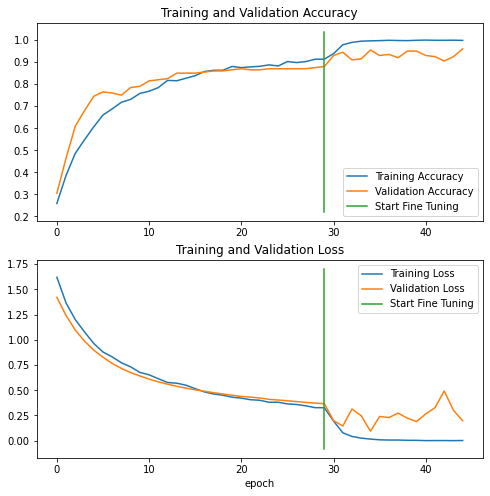

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# PREDICTIONS
predictions = model.predict(x=test_batches, verbose=0)

In [ ]:
# calculating CONFUSION MATRIX
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

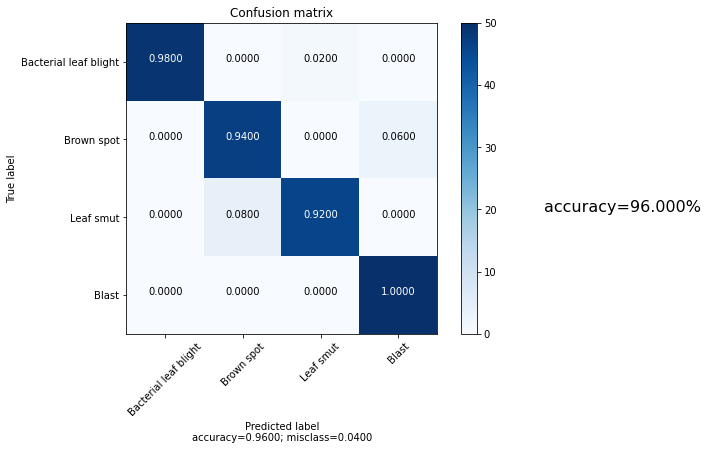

In [ ]:
plot_confusion_matrix(cm, classes)

# Save Model

In [ ]:
from datetime import datetime
t = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
accuracy = (np.trace(cm) / np.sum(cm).astype('float'))*100
model.save(f"/content/drive/My Drive/8th_sem_project/Latest/Densenet201_acc{accuracy:02.3f}.h5")